In [39]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import shape

In [3]:
# Charge le shapefile
gdf = gpd.read_file("data/RPG_2023/PARCELLES_GRAPHIQUES.gpkg")

In [ ]:
gdf  = gdf.to_crs(epsg=4326)

In [4]:
gdf["SURF_PARC"].median()

np.float32(1.24)

In [5]:
# Charger le fichier Excel 
correspondance = pd.read_excel("data/correspondances.xlsx", sheet_name="1")

# 'code_culture' et 'nom_culture'
correspondance.columns = correspondance.columns.str.strip()  # nettoyage des noms de colonnes

# Ajouter la colonne 'NOM_CULTURE' 
gdf = gdf.merge(correspondance, how="left", left_on="CODE_CULTU", right_on="code_culture")

gdf = gdf.rename(columns={"nom_culture": "NOM_CULTURE"})

gdf

,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,geometry,code_culture,NOM_CULTURE
0,1,5.01,ORH,3,,,"POLYGON ((620859.121 7049174.538, 621155.742 7...",ORH,Orge d’hiver
1,2,0.43,TRN,6,,,"POLYGON ((518271.056 6380847.362, 518271.088 6...",TRN,Tournesol
2,3,2.34,BTH,1,,,"POLYGON ((653603.846 6971494.032, 653548.732 6...",BTH,Blé tendre d’hiver
3,4,2.31,VRC,21,,,"POLYGON ((450066.555 6519505.157, 449911.365 6...",VRC,Vigne (sauf vigne rouge)
4,5,0.14,SNE,28,,,"POLYGON ((542585.535 6905398.389, 542579.8 690...",SNE,Surface agricole temporairement non admissible...
...,...,...,...,...,...,...,...,...,...
9797400,9866940,0.06,SPH,17,,,"POLYGON ((941769.023 6407193.483, 941769.35 64...",SPH,Prairie avec herbe prédominante et ressources ...
9797401,9866941,0.17,BOR,28,,,"POLYGON ((749684.059 6617162.615, 749683.959 6...",BOR,Bordure de champ
9797402,9866942,3.78,MIS,2,,,"POLYGON ((640902.575 6310402.873, 640902.561 6...",MIS,Maïs (hors maïs doux)
9797403,9866943,3.44,MIS,2,,,"POLYGON ((889837.386 6687978.699, 889853.479 6...",MIS,Maïs (hors maïs doux)


In [6]:
gdf['NOM_CULTURE'].value_counts()


NOM_CULTURE
Prairie de 6 ans et plus (couvert herbacé)                                                                           3043081
Blé tendre d’hiver                                                                                                    885083
Maïs (hors maïs doux)                                                                                                 710194
Prairie temporaire de 5 ans ou moins et autre mélange avec graminées                                                  703112
Jachère (terre arable)                                                                                                572050
                                                                                                                      ...   
Autre culture pérenne et jachère dans les bananeraies                                                                    103
Cultures conduites en inter-rangs (bandes de cultures différentes) – 3 cultures représentant chacune plus de 25 %

In [7]:
gdf_filtered = gdf[(gdf['SURF_PARC'] > 2)]


counts = gdf_filtered['CODE_CULTU'].value_counts()
valid_classes = counts[counts > 15000].index
gdf_filtered = gdf_filtered[gdf_filtered['CODE_CULTU'].isin(valid_classes)]


print(gdf_filtered['NOM_CULTURE'].value_counts(), len(gdf_filtered['CODE_CULTU'].value_counts()), sum(gdf_filtered['CODE_CULTU'].value_counts()))

NOM_CULTURE
Prairie de 6 ans et plus (couvert herbacé)                                              1053420
Blé tendre d’hiver                                                                       609231
Maïs (hors maïs doux)                                                                    395267
Prairie temporaire de 5 ans ou moins et autre mélange avec graminées                     244777
Orge d’hiver                                                                             182955
Colza d’hiver                                                                            164131
Tournesol                                                                                110096
Prairie avec herbe prédominante et ressources fourragères ligneuses présentes             81319
Vigne (sauf vigne rouge)                                                                  74223
Luzerne                                                                                   71774
Triticale d’hiver           

In [20]:
n = 100 # nombre par culture
sample = (
    gdf_filtered.groupby("CODE_CULTU", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n), random_state=42))
)

In [21]:
sample["SURF_PARC"].sum()

np.float32(13976.4795)

In [22]:
sample.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2100 entries, 6747702 to 6162497
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ID_PARCEL     2100 non-null   object  
 1   SURF_PARC     2100 non-null   float32 
 2   CODE_CULTU    2100 non-null   object  
 3   CODE_GROUP    2100 non-null   object  
 4   CULTURE_D1    2100 non-null   object  
 5   CULTURE_D2    2100 non-null   object  
 6   geometry      2100 non-null   geometry
 7   code_culture  2100 non-null   object  
 8   NOM_CULTURE   2100 non-null   object  
dtypes: float32(1), geometry(1), object(7)
memory usage: 155.9+ KB


In [24]:
#sampled = sample.head(1)
sampled = sample
sampled

,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,geometry,code_culture,NOM_CULTURE
6747702,6795423,21.370001,BDH,4,,,"POLYGON ((517492.146 6321037.224, 517497.528 6...",BDH,Blé dur d’hiver
6601093,6647802,3.900000,BDH,4,,,"POLYGON ((390217.291 6539527.808, 390235.211 6...",BDH,Blé dur d’hiver
1900563,1914059,5.520000,BDH,4,,,"POLYGON ((847493.143 6411449.135, 847513.353 6...",BDH,Blé dur d’hiver
695096,699964,4.260000,BDH,4,,,"POLYGON ((812313.277 6303169.877, 812496.498 6...",BDH,Blé dur d’hiver
1892395,1905827,5.440000,BDH,4,,,"POLYGON ((606116.001 6787852.367, 606024.297 6...",BDH,Blé dur d’hiver
...,...,...,...,...,...,...,...,...,...
8005804,8062578,3.800000,VRC,21,,,"POLYGON ((459639.853 6519201.747, 459591.411 6...",VRC,Vigne (sauf vigne rouge)
456078,459234,4.770000,VRC,21,,,"POLYGON ((703163.249 6241133.536, 703206.177 6...",VRC,Vigne (sauf vigne rouge)
6619078,6665904,2.160000,VRC,21,,,"POLYGON ((824067.954 6337123.027, 824029.563 6...",VRC,Vigne (sauf vigne rouge)
3020647,3042041,3.830000,VRC,21,,,"POLYGON ((436139.449 6491680.187, 436227.946 6...",VRC,Vigne (sauf vigne rouge)


In [121]:
import ee 
import geemap

In [126]:
ee.Authenticate(scopes=['https://www.googleapis.com/auth/earthengine',
                        'https://www.googleapis.com/auth/drive'])
ee.Initialize()


Successfully saved authorization token.


In [127]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [128]:
#### selectionner un polygone fait à la mano sur Map

polygone_hand_draw = Map.draw_features  

first_polygone = polygone_hand_draw[0] 

geom_hand_poly = first_polygone.geometry()

geom_hand_poly

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          1.432943,
                          48.940374
                        ],
                        [
                          1.432943,
                          48.960891
                        ],
                        [
                          1.475601,
                          48.960891
                        ],
                        [
                          1.475601,
                          48.940374
                        ],
                        [
                          1.432943,
                          48.940374
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [129]:

#  Convertir ee.Geometry en GeoJSON dict
geom_hand_poly_json = geom_hand_poly.getInfo()

#  Convertir GeoJSON dict en shapely geometry
hand_poly_shapely = shape(geom_hand_poly_json)


# Filtrer le GeoDataFrame pour ne garder que les polygones contenus dans geom_hand_poly
gdf_contained = gdf[gdf.geometry.within(hand_poly_shapely)]

In [130]:
# Convertir en GeoJSON pour l'affichage (sert à convertir un GeoDataFrame en un dictionnaire au format GeoJSON natif)
Parcelle_within_hand_Poly_geojson = gdf_contained.__geo_interface__

# Convertir en GEE FeatureCollection
fc = geemap.geopandas_to_ee(gdf_contained, geodesic=False)
fc_geom = fc.geometry()


In [131]:
############ Import raster from the selected zone (hand poly )


Geometry_data_collect = geom_hand_poly

# Get the area value
area_m2 = geom_hand_poly.area(maxError=1)
print("Area (m²):", area_m2.getInfo())

Area (m²): 7106540.994780825


In [ ]:
start_date = '2023-01-01'
end_date = '2023-12-31'

# Créer une ImageCollection NDVI Sentinel-2
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(Geometry_data_collect) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .map(lambda img: img.clip(fc.geometry()))  # Clip aux parcelles
    

In [132]:
############# image collection of the selected zone 

# Créer une ImageCollection Sentinel-2 (niveau 2A = atmosphériquement corrigée avec Sen2Cor) La correction atmosphérique — réalisée par Sen2Cor dans les produits Sentinel-2 Level-2A — transforme les images satellites pour qu'elles reflètent la vraie réflectance du sol, en supprimant les effets de l’atmosphère.
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(Geometry_data_collect) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .map(lambda img: img.clip(Geometry_data_collect)) \
    .select(['B2', 'B3', 'B4', 'B8'])  # B2: Blue, B3: Green, B4: Red, B8: NIR (tous à 10 m)

# Pas de filtrage par CLOUDY_PIXEL_PERCENTAGE (comme dans le papier)
# Pas besoin de resample ici si on utilise déjà des bandes à 10 m

# Tu peux aussi ajouter un tri temporel :
s2 = s2.sort('system:time_start')

In [133]:
s2


In [134]:
s2_firts = s2.first()

In [135]:
# Fonction pour réaligner chaque image sur la grille de l’image de référence

def align_to_reference(img):
    return img.resample('bilinear').reproject(
        crs= s2_firts.projection().crs(),
        scale=10
    ).clip(Geometry_data_collect)


# 6. Appliquer l’alignement à toute la collection
s2_aligned = s2.map(align_to_reference)

In [136]:
s2_aligned

In [140]:
########## export des tiff

# Récupérer la liste des images
image_list = s2_aligned.toList(s2_aligned.size())

# Nombre d’images
n = s2_aligned.size().getInfo()

for i in range(n):
    image = ee.Image(image_list.get(i)).clip(Geometry_data_collect)
    
    # Construire un nom unique, par exemple date acquisition
    date_str = image.date().format('YYYYMMdd').getInfo()
    task = ee.batch.Export.image.toDrive(
        image=image,
        description='test_s2_aligne_10CloudCover',
        folder='GEE_exports_test1',
        fileNamePrefix=f'sentinel2_{i}_{date_str}',
        region=Geometry_data_collect,
        scale=10,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task.start()
    print(f"Export lancé pour l’image {i+1}/{n}, date : {date_str}")

Export lancé pour l’image 1/17, date : 20230207
Export lancé pour l’image 2/17, date : 20230214
Export lancé pour l’image 3/17, date : 20230227
Export lancé pour l’image 4/17, date : 20230525
Export lancé pour l’image 5/17, date : 20230528
Export lancé pour l’image 6/17, date : 20230602
Export lancé pour l’image 7/17, date : 20230604
Export lancé pour l’image 8/17, date : 20230607
Export lancé pour l’image 9/17, date : 20230614
Export lancé pour l’image 10/17, date : 20230624
Export lancé pour l’image 11/17, date : 20230821
Export lancé pour l’image 12/17, date : 20230902
Export lancé pour l’image 13/17, date : 20230907
Export lancé pour l’image 14/17, date : 20230915
Export lancé pour l’image 15/17, date : 20231007
Export lancé pour l’image 16/17, date : 20231206
Export lancé pour l’image 17/17, date : 20231216


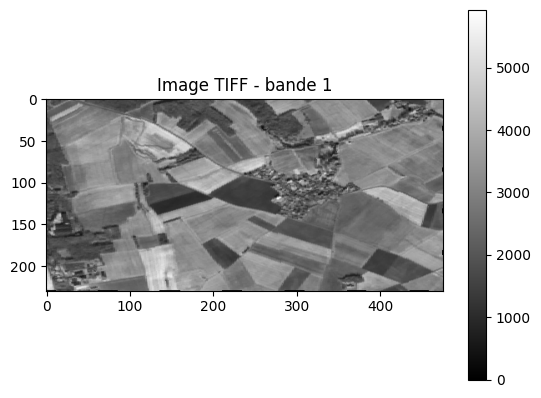

In [154]:
import rasterio
import matplotlib.pyplot as plt

# Ouvrir le fichier TIFF
with rasterio.open('/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_exports_test1/sentinel2_0_20230207.tif') as src:
    img = src.read(4)  # lire la première bande

plt.imshow(img, cmap='gray')  # ou 'viridis', 'jet', etc.
plt.colorbar()
plt.title('Image TIFF - bande 1')
plt.show()

src.close()

In [153]:
img

array([[2744, 2708, 2708, ...,    0,    0,    0],
       [2503, 2328, 2328, ..., 3120, 3300, 3300],
       [2174, 2186, 2186, ..., 3216, 3200, 3200],
       ...,
       [3132, 4848, 5175, ..., 2811, 2750, 2796],
       [2237, 4091, 4732, ..., 2708, 2750, 2774],
       [   0,    0,    0, ..., 2766, 2711, 2663]],
      shape=(230, 476), dtype=uint16)

In [152]:
################ visualisation 
s2_firts = s2.first()

# Définir les paramètres d'affichage (Red: B4, Green: B3, Blue: B2)
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 3000,
    'gamma': 1.3
}

# Ajouter à la carte
Map.centerObject(fc, zoom=10)  # centrer sur ta zone d’intérêt (fc)
# Ajouter les polygones du shapefile
Map.add_geojson(Parcelle_within_hand_Poly_geojson, layer_name="Parcelles")
Map.addLayer(s2_firts, vis_params, 'Sentinel-2 RGB')
Map

Map(bottom=22586.0, center=[48.950508015255934, 1.4536461387956117], controls=(WidgetControl(options=['positio…

In [67]:
s2_firts.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 5500020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 5500020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 5500020]},
  {'id': 'B8',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -